In [1]:
import scanpy as sc
from lightning.pytorch import Trainer, seed_everything

from scprint import scPrint
from scprint.tasks import Embedder

from scdataloader import Preprocessor
from scdataloader.utils import load_genes, translate

import numpy as np
import pandas as pd

from scib_metrics.benchmark import Benchmarker

import matplotlib.pyplot as plt

from collections import Counter

%load_ext autoreload
%autoreload 2

import torch
torch.set_float32_matmul_precision('medium')


💡 loaded instance: jkobject/scprint


## preparing the model

In [2]:
#model = scPrint.load_from_checkpoint('../../data/tensorboard/scprint_test/urxxwu28/checkpoints/epoch=0-step=20000.ckpt') #chocolate-surf-8
model = scPrint.load_from_checkpoint('../../data/temp/pk2sldhk/epoch=6-step=35000.ckpt', precpt_gene_emb = '../../data/temp/embeddings.parquet')
# ../../data/temp/epoch=4-step=12500.ckpt latest model maestro (fortuitous laugther)
# ../../data/logs/scprint_test/f4vao230/checkpoints/epoch=10-step=27500.ckpt looked good as a training run (vermlillion noodle)
# d1792z9k/epoch=3-step=10000.ckpt
# '../../data/temp/d1792z9k/epoch=3-step=10000.ckpt'
# '../../data/temp/6q3dzi3x/epoch=3-step=10000.ckpt'
# '../../data/temp/grsachbg/epoch=2-step=15000.ckpt'
## post debug
# "../lightning_logs/version_14/checkpoints/epoch=1-step=5000.ckpt"

/home/ml4ig1/miniconda3/envs/scprint/lib/python3.10/site-packages/lightning/pytorch/utilities/migration/utils.py:55: PossibleUserWarning: The loaded checkpoint was produced with Lightning v2.2.0.post0, which is newer than your current Lightning version: v2.0.9.post0
  rank_zero_warn(


In [ ]:
print(model)

scPrint(
  (gene_encoder): GeneEncoder(
    (embedding): Embedding(33890, 256)
    (enc_norm): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (expr_encoder): ContinuousValueEncoder(
    (encoder): ModuleList(
      (0): Linear(in_features=1, out_features=256, bias=True)
      (1): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
      (2): ReLU()
      (3): Dropout(p=0.1, inplace=False)
    )
  )
  (pos_encoder): PositionalEncoding(
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (label_encoder): CategoryValueEncoder(
    (embedding): Embedding(8, 256)
    (enc_norm): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
  )
  (depth_decoder): ContinuousValueEncoder(
    (encoder): ModuleList(
      (0): Linear(in_features=1, out_features=256, bias=True)
      (1): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
      (2): ReLU()
      (3): Dropout(p=0.1, inplace=False)
    )
  )
  (transformer): FlashTransformerEn

## Loading the data

In [ ]:
#only dataset dropped
adata = sc.read_h5ad('/home/ml4ig1/scprint/.lamindb/z7ZZxORUQFshySbuvNW7.h5ad') 

# one that it trained on: z7ZZxORUQFshySbuvNW7.
# untrained on: BljRloq1xjcxRNDpejzI

In [10]:
adata = sc.read(
    "data/pancreas_atlas.h5ad",
    backup_url="https://figshare.com/ndownloader/files/24539828",
)


/home/ml4ig1/miniconda3/envs/scprint/lib/python3.10/site-packages/anndata/__init__.py:51: FutureWarning: `anndata.read` is deprecated, use `anndata.read_h5ad` instead. `ad.read` will be removed in mid 2024.
  warnings.warn(


In [3]:
adata = sc.read(
    "data/lung_atlas.h5ad",
    backup_url="https://figshare.com/ndownloader/files/24539942",
)

/home/ml4ig1/miniconda3/envs/scprint/lib/python3.10/site-packages/anndata/__init__.py:51: FutureWarning: `anndata.read` is deprecated, use `anndata.read_h5ad` instead. `ad.read` will be removed in mid 2024.
  warnings.warn(


In [4]:
preprocessor = Preprocessor(subset_hvg=1000, use_layer='counts', is_symbol=True, force_preprocess=True, skip_validate=True, do_postp=False)

In [5]:
adata.obs['organism_ontology_term_id'] = "NCBITaxon:9606"
adata = preprocessor(adata.copy())

Data is not raw counts, please check layers, find raw data, or bypass with force_preprocess
Removed 0 genes.
Seeing 10331 outliers (32.03% of total dataset):


/home/ml4ig1/miniconda3/envs/scprint/lib/python3.10/site-packages/scanpy/preprocessing/_highly_variable_genes.py:61: UserWarning: `flavor='seurat_v3'` expects raw count data, but non-integers were found.
  warnings.warn(


In [20]:
adata

View of AnnData object with n_obs × n_vars = 16382 × 70116
    obs: 'tech', 'celltype', 'size_factors', 'organism_ontology_term_id', 'nnz', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'outlier', 'mt_outlier'
    var: 'uid', 'symbol', 'stable_id', 'ncbi_gene_ids', 'biotype', 'description', 'synonyms', 'organism_id', 'public_source_id', 'created_at', 'updated_at', 'created_by_id', 'mt', 'ribo', 'hb', 'organism', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm'
    uns: 'unseen_genes', 'hvg'
    layers: 'clean'

In [ ]:
sc.pl.umap(adata, color=["cell_type", "development_stage", "assay", "disease", "sex", "self_reported_ethnicity"])

In [6]:
Counter(adata.obs.cell_type)

Counter({'Macrophage': 7433,
         'Type 2': 4246,
         'Ciliated': 3145,
         'Basal 2': 3072,
         'Secretory': 2433,
         'Basal 1': 1972,
         'T/NK cell': 1771,
         'Neutrophil_CD14_high': 1626,
         'Dendritic cell': 1367,
         'B cell': 1331,
         'Endothelium': 978,
         'Mast cell': 877,
         'Fibroblast': 730,
         'Neutrophils_IL1R2': 472,
         'Type 1': 418,
         'Lymphatic': 334,
         'Ionocytes': 46})

# good dataset

In [7]:
trainer = Trainer(precision="16-mixed")

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [8]:
from scdataloader.data import SimpleAnnDataset
from scdataloader import Collator
from torch.utils.data import DataLoader

In [15]:
subadata

AnnData object with n_obs × n_vars = 699 × 19093
    obs: 'tech', 'celltype', 'size_factors', 'organism_ontology_term_id'
    var: 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm'
    uns: 'hvg'
    layers: 'counts'

In [10]:
organisms=[
    "NCBITaxon:9606",
]
subadata = adata[adata.obs.cell_type=="B cell"]
subadata.obs['organism_ontology_term_id'] = organisms[0]
print(subadata)

sc.pp.highly_variable_genes(subadata, n_top_genes=3000, flavor='seurat_v3')
highly_variable = subadata.var.index[subadata.var.highly_variable].tolist()
print((subadata.X.sum(0)>1).sum())

adataset = SimpleAnnDataset(
    subadata, obs_to_output=["organism_ontology_term_id"]
)
col = Collator(
    organisms=organisms,
    valid_genes=model.genes,
    how="some",
    genelist=highly_variable,
)
dataloader = DataLoader(
    adataset,
    collate_fn=col,
    batch_size=64,
    num_workers=1,
    shuffle=False,
)
model.get_attention_layer=[3]
# self.trainer.num_predict_batches = 1

/tmp/ipykernel_427718/2357743840.py:5: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  subadata.obs['organism_ontology_term_id'] = organisms[0]


AnnData object with n_obs × n_vars = 1331 × 70116
    obs: 'dataset', 'location', 'nGene', 'nUMI', 'patientGroup', 'percent.mito', 'protocol', 'sanger_type', 'size_factors', 'sampling_method', 'batch', 'cell_type', 'donor', 'organism_ontology_term_id', 'nnz', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'outlier', 'mt_outlier'
    var: 'uid', 'symbol', 'stable_id', 'ncbi_gene_ids', 'biotype', 'description', 'synonyms', 'organism_id', 'public_source_id', 'created_at', 'updated_at', 'created_by_id', 'mt', 'ribo', 'hb', 'organism', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm'
   

/home/ml4ig1/miniconda3/envs/scprint/lib/python3.10/site-packages/scanpy/preprocessing/_highly_variable_genes.py:61: UserWarning: `flavor='seurat_v3'` expects raw count data, but non-integers were found.
  warnings.warn(


12523



LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/ml4ig1/miniconda3/envs/scprint/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:442: PossibleUserWarning: The dataloader, predict_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 40 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Predicting: 0it [00:00, ?it/s]

/home/ml4ig1/miniconda3/envs/scprint/lib/python3.10/site-packages/lightning/pytorch/loops/prediction_loop.py:234: UserWarning: predict returned None if it was on purpose, ignore this warning...
  self._warning_cache.warn("predict returned None if it was on purpose, ignore this warning...")
/home/ml4ig1/miniconda3/envs/scprint/lib/python3.10/site-packages/anndata/_core/anndata.py:183: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


         Falling back to preprocessing with `sc.pp.pca` and default params.


/home/ml4ig1/miniconda3/envs/scprint/lib/python3.10/site-packages/anndata/_core/anndata.py:522: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(


AnnData object with n_obs × n_vars = 1331 × 256
    obs: 'pred_cell_type_ontology_term_id', 'pred_disease_ontology_term_id', 'pred_assay_ontology_term_id', 'pred_self_reported_ethnicity_ontology_term_id', 'pred_sex_ontology_term_id', 'pred_organism_ontology_term_id', 'conv_pred_cell_type_ontology_term_id', 'conv_pred_disease_ontology_term_id', 'conv_pred_assay_ontology_term_id', 'conv_pred_self_reported_ethnicity_ontology_term_id', 'leiden'
    uns: 'neighbors', 'umap', 'leiden'
    obsm: 'X_pca', 'X_umap'
    obsp: 'distances', 'connectivities'


/home/ml4ig1/miniconda3/envs/scprint/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/home/ml4ig1/miniconda3/envs/scprint/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/ml4ig1/miniconda3/envs/scprint/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(

couldn't log to tensorboard
couldn't log to wandb


[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

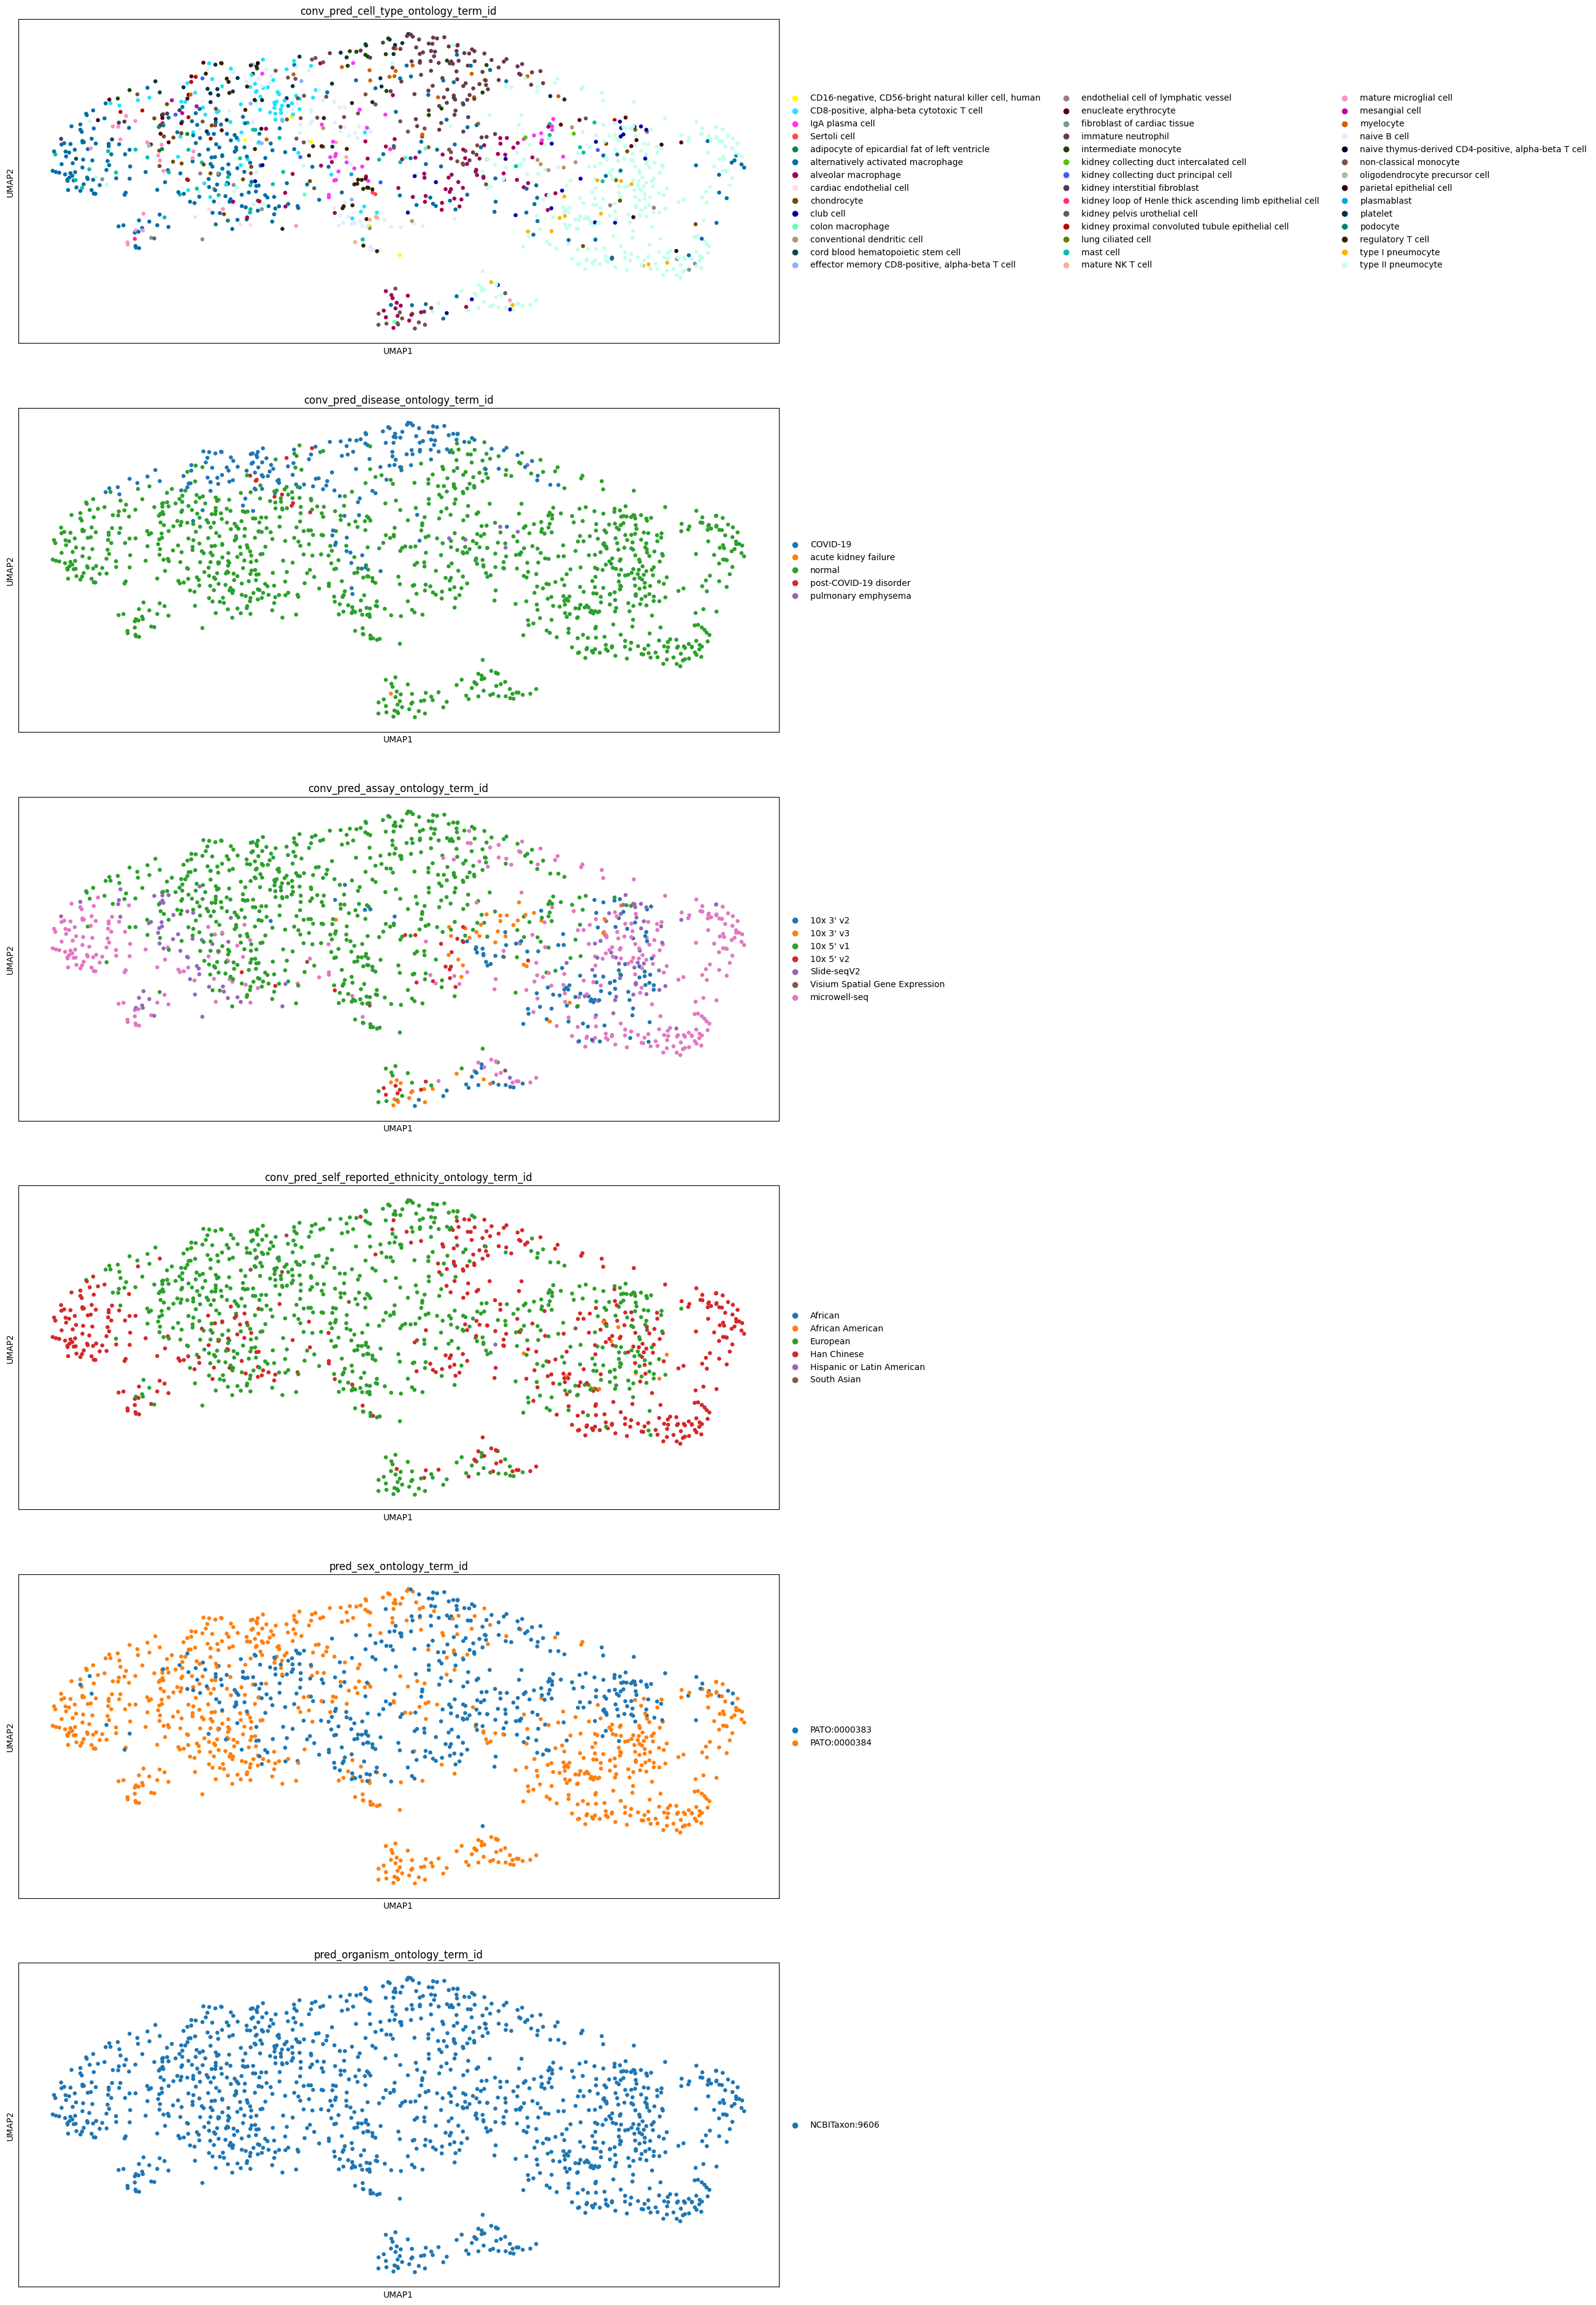

In [11]:
trainer.predict(model, dataloader)

In [14]:
from scprint.utils.sinkhorn import SinkhornDistance

In [13]:
model.mean_attn[0][8:].shape

torch.Size([2934, 2, 4, 64])

In [ ]:
# queries are on the rows, keys are on the columns
# queries are the targets, keys are the regulators

In [17]:
attn = model.mean_attn[0][8:][:,0,:,:].permute(1,0,2) @ model.mean_attn[0][8:][:,1,:,:].permute(1,2,0)
scale = model.mean_attn[0].shape[-1] ** -0.5
attn = attn * scale

sink = SinkhornDistance(0.1, max_iter=200)
a = sink(attn)[0]
a = a * a.shape[-1]

a = a.mean(0).detach().cpu().numpy()
print("avg link count: "+str((a>(1/attn.shape[-1])).sum() / attn.shape[-1]))
a[a<(1/a.shape[-1])] = 0
print((a==0).sum(), a.min(), a.max())

avg link count: 191.55760054533062

8046326 0.0 0.411


In [20]:
from grnndata import GRNAnnData
from grnndata import utils 

In [21]:
grn = GRNAnnData(subadata[:,col.accepted_genes[organisms[0]]][:,col.to_subset[organisms[0]]].copy(), grn=a)

In [22]:
top_central_genes = utils.get_centrality(grn)
grn.var.loc[[i[0] for i in top_central_genes],'symbol']

grn.var_names = grn.var['symbol']
grn.var['TFs'] = [True if i in utils.TF else False for i in grn.var_names]

grn.var = grn.var.drop(columns=["stable_id", "created_at", "updated_at"])
grn.write('grn_b_cell.h5ad')

Top central genes: [('ENSG00000133704', 0.040653944528436486), ('ENSG00000047621', 0.04064446131790098), ('ENSG00000114999', 0.03949920309655611), ('ENSG00000139631', 0.03946605589859195), ('ENSG00000107021', 0.0393264734514244), ('ENSG00000115204', 0.03930361606371321), ('ENSG00000094880', 0.03838121796420016), ('ENSG00000186104', 0.03831559067228271), ('ENSG00000168411', 0.0381910845104863), ('ENSG00000123453', 0.037697312137381145), ('ENSG00000113456', 0.037518558945210195), ('ENSG00000113504', 0.03723922640312248), ('ENSG00000100601', 0.0371668538116796), ('ENSG00000161920', 0.03707635908526432), ('ENSG00000090372', 0.03702656143312264), ('ENSG00000137364', 0.037014306327347105), ('ENSG00000133422', 0.03698463894996278), ('ENSG00000134899', 0.03687673429260686), ('ENSG00000196943', 0.03677144370308653), ('ENSG00000082213', 0.03673542898762516), ('ENSG00000164118', 0.03667254953429978), ('ENSG00000107758', 0.036631110885400005), ('ENSG00000104835', 0.03662828441272299), ('ENSG000001

... storing 'organism_ontology_term_id' as categorical
... storing 'ncbi_gene_ids' as categorical
... storing 'biotype' as categorical
... storing 'synonyms' as categorical
... storing 'organism' as categorical


In [23]:
res = utils.enrichment(grn, of='Central')

Top central genes: []


2024-03-09 17:35:15,747 [INFO] Parsing data files for GSEA.............................
2024-03-09 17:35:15,749 [INFO] Enrichr library gene sets already downloaded in: /home/ml4ig1/.cache/gseapy, use local file
2024-03-09 17:35:15,755 [INFO] Enrichr library gene sets already downloaded in: /home/ml4ig1/.cache/gseapy, use local file
2024-03-09 17:35:16,037 [INFO] Enrichr library gene sets already downloaded in: /home/ml4ig1/.cache/gseapy, use local file
2024-03-09 17:35:16,056 [INFO] Enrichr library gene sets already downloaded in: /home/ml4ig1/.cache/gseapy, use local file
2024-03-09 17:35:16,058 [INFO] Enrichr library gene sets already downloaded in: /home/ml4ig1/.cache/gseapy, use local file
2024-03-09 17:35:16,064 [INFO] Enrichr library gene sets already downloaded in: /home/ml4ig1/.cache/gseapy, use local file
2024-03-09 17:35:16,700 [ERROR] No supported gene_sets: GTEx_Tissue_Sample_Gene_Expression_Profiles_up
2024-03-09 17:35:16,703 [INFO] Enrichr library gene sets already downlo

[]


/home/ml4ig1/Documents code/GRnnData/grnndata/utils.py:221: DeprecationWarning: invalid escape sequence '\m'
  """


ValueError: Warning: No enrich terms when cutoff = 0.25

In [24]:
utils.enrichment(grn, of='Regulators')

2024-03-09 17:42:10,509 [WARNING] Duplicated values found in preranked stats: 81.63% of genes
The order of those genes will be arbitrary, which may produce unexpected results.
2024-03-09 17:42:10,512 [INFO] Parsing data files for GSEA.............................
2024-03-09 17:42:10,514 [INFO] Enrichr library gene sets already downloaded in: /home/ml4ig1/.cache/gseapy, use local file
2024-03-09 17:42:10,525 [INFO] Enrichr library gene sets already downloaded in: /home/ml4ig1/.cache/gseapy, use local file
2024-03-09 17:42:11,039 [INFO] Enrichr library gene sets already downloaded in: /home/ml4ig1/.cache/gseapy, use local file
2024-03-09 17:42:11,095 [INFO] Enrichr library gene sets already downloaded in: /home/ml4ig1/.cache/gseapy, use local file
2024-03-09 17:42:11,098 [INFO] Enrichr library gene sets already downloaded in: /home/ml4ig1/.cache/gseapy, use local file
2024-03-09 17:42:11,153 [INFO] Enrichr library gene sets already downloaded in: /home/ml4ig1/.cache/gseapy, use local fil

[]


ValueError: Warning: No enrich terms when cutoff = 0.25

2024-03-09 17:43:17,010 [WARNING] Duplicated values found in preranked stats: 43.18% of genes
The order of those genes will be arbitrary, which may produce unexpected results.
2024-03-09 17:43:17,013 [INFO] Parsing data files for GSEA.............................
2024-03-09 17:43:17,015 [INFO] Enrichr library gene sets already downloaded in: /home/ml4ig1/.cache/gseapy, use local file
2024-03-09 17:43:17,025 [INFO] Enrichr library gene sets already downloaded in: /home/ml4ig1/.cache/gseapy, use local file
2024-03-09 17:43:17,568 [INFO] Enrichr library gene sets already downloaded in: /home/ml4ig1/.cache/gseapy, use local file
2024-03-09 17:43:17,608 [INFO] Enrichr library gene sets already downloaded in: /home/ml4ig1/.cache/gseapy, use local file
2024-03-09 17:43:17,611 [INFO] Enrichr library gene sets already downloaded in: /home/ml4ig1/.cache/gseapy, use local file
2024-03-09 17:43:17,620 [INFO] Enrichr library gene sets already downloaded in: /home/ml4ig1/.cache/gseapy, use local fil

['GO_Cellular_Component_2015__mitochondrial membrane part (GO:0044455)', 'WikiPathways_2016__MAPK Cascade Homo sapiens WP422', 'WikiPathways_2016__MAPK Cascade Mus musculus WP251', 'GO_Cellular_Component_2015__intermediate filament cytoskeleton (GO:0045111)', 'ENCODE_TF_ChIP-seq_2014__TR4 HELA-S3', 'PPI_Hub_Proteins__SSZ1', 'GO_Cellular_Component_2015__respiratory chain complex I (GO:0045271)', 'GO_Cellular_Component_2015__mitochondrial respiratory chain complex I (GO:0005747)', 'GO_Cellular_Component_2015__NADH dehydrogenase complex (GO:0030964)', 'ENCODE_TF_ChIP-seq_2014__TR4 K562', 'PPI_Hub_Proteins__PARP1', 'GO_Cellular_Component_2015__peroxisome (GO:0005777)', 'PPI_Hub_Proteins__RRP5', 'ENCODE_TF_ChIP-seq_2014__GABP HELA-S3', 'WikiPathways_2016__IL-1 signaling pathway Homo sapiens WP195']


/home/ml4ig1/miniconda3/envs/scprint/lib/python3.10/site-packages/gseapy/plot.py:689: FutureWarning: The 'method' keyword in Series.replace is deprecated and will be removed in a future version.
  df[self.colname].replace(
/home/ml4ig1/miniconda3/envs/scprint/lib/python3.10/site-packages/gseapy/plot.py:689: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[self.colname].replace(


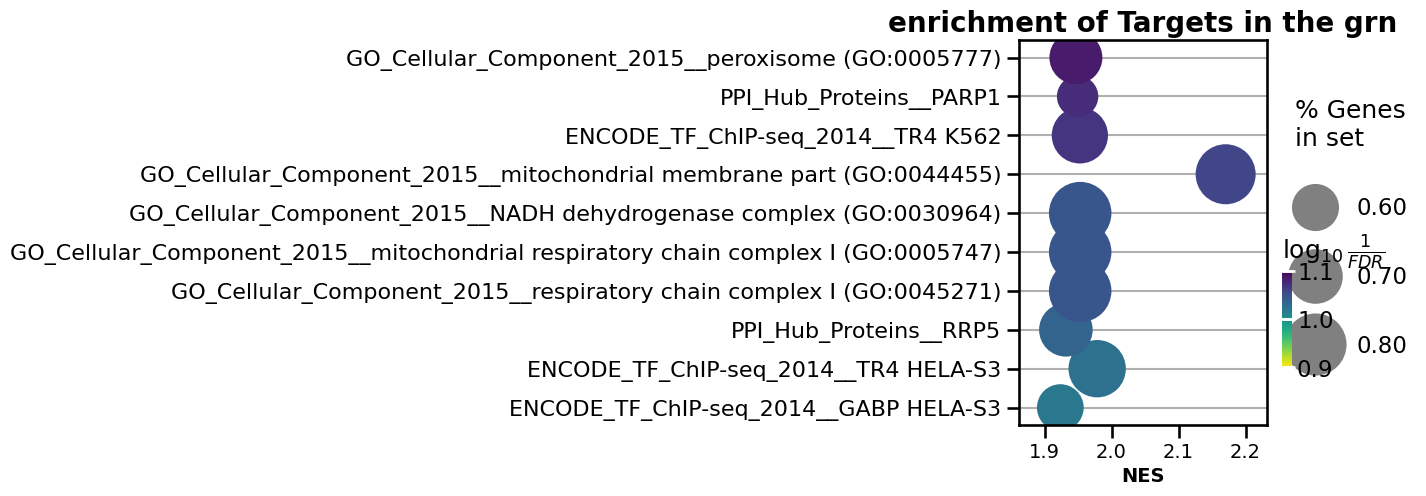

In [26]:
# queries in the attn matrix
res = utils.enrichment(grn, of='Targets')

In [27]:
res

,Term,ES,NES,NOM p-val,FDR q-val,FWER p-val,Tag %,Gene %,Lead_genes
33,GO_Cellular_Component_2015__mitochondrial memb...,0.583382,2.170359,0.0,0.087508,0.078,16/20,30.47%,MT-CO1;MT-ATP8;NDUFAF1;MT-ND4L;TIMM10;MT-ND5;U...
53,WikiPathways_2016__MAPK Cascade Homo sapiens W...,0.835511,1.990504,0.0,0.0968,0.58,4/5,9.51%,ELK1;SIPA1;MAP2K6;MAP3K1
54,WikiPathways_2016__MAPK Cascade Mus musculus W...,0.835511,1.990504,0.0,0.0968,0.58,4/5,9.51%,ELK1;SIPA1;MAP2K6;MAP3K1
55,GO_Cellular_Component_2015__intermediate filam...,0.664803,1.981828,0.0,0.098744,0.623,7/10,17.79%,ERCC5;CLK3;SMNDC1;DDX60;SYNE2;CENPQ;IP6K2
56,ENCODE_TF_ChIP-seq_2014__TR4 HELA-S3,0.419775,1.97859,0.0,0.094124,0.639,52/68,43.63%,SRP54;SRFBP1;LRIF1;BRD8;RNF121;SMARCD2;INTS4;Z...
57,PPI_Hub_Proteins__SSZ1,0.569452,1.968804,0.0,0.096738,0.682,10/15,25.60%,RPL10;USO1;GBP2;UTP23;SMC6;RPL3;RAD1;RAI1;FAR1...
59,GO_Cellular_Component_2015__respiratory chain ...,0.762618,1.953215,0.001277,0.08979,0.757,5/6,14.59%,NDUFAF1;MT-ND4L;MT-ND5;MT-ND1;MT-ND2
60,GO_Cellular_Component_2015__mitochondrial resp...,0.762618,1.953215,0.001277,0.08979,0.757,5/6,14.59%,NDUFAF1;MT-ND4L;MT-ND5;MT-ND1;MT-ND2
61,GO_Cellular_Component_2015__NADH dehydrogenase...,0.762618,1.953215,0.001277,0.08979,0.757,5/6,14.59%,NDUFAF1;MT-ND4L;MT-ND5;MT-ND1;MT-ND2
62,ENCODE_TF_ChIP-seq_2014__TR4 K562,0.476858,1.952744,0.001027,0.085353,0.761,24/32,36.50%,TIMMDC1;LRIF1;RNF121;SMARCD2;THAP1;HMGXB4;RSRC...


In [47]:
torch.cuda.empty_cache()

In [4]:
from grnndata import GRNAnnData, from_anndata, read_h5ad, from_embeddings
from grnndata import utils 

import bengrn as ben

In [5]:
grn = read_h5ad('grn_b_cell.h5ad')
# utils.plot_cluster(grn)

In [11]:
umap.UMAP(n_neighbors=40,
min_dist=0.4,
precomputed_knn=grn.varp['GRN'],
)

UMAP(min_dist=0.4, n_neighbors=40, precomputed_knn=array([[0.      , 0.      , 0.      , ..., 0.      , 0.      , 0.      ],
       [0.      , 0.      , 0.      , ..., 0.      , 0.      , 0.      ],
       [0.      , 0.      , 0.      , ..., 0.      , 0.      , 0.      ],
       ...,
       [0.      , 0.      , 0.005116, ..., 0.      , 0.      , 0.      ],
       [0.      , 0.      , 0.      , ..., 0.      , 0.      , 0.      ],
       [0.      , 0.      , 0.      , ..., 0.      , 0.      , 0.      ]],
      dtype=float16))

In [17]:
import scanpy as sc

In [21]:
tgrn = grn.T

In [38]:
sc.tl.louvain(tgrn, adjacency=tgrn.obsp["GRN"], resolution=1.2)

In [39]:
tgrn.obs['louvain']

symbol
TSPAN6      0
ANKIB1      3
CYP51A1     1
LASP1       1
TMEM176A    0
           ..
PCGF2       3
MARCKS      0
ZNF670      1
DDX52       0
TBCE        2
Name: louvain, Length: 2934, dtype: category
Categories (14, object): ['0', '1', '2', '3', ..., '10', '11', '12', '13']

In [ ]:
import umap

In [46]:
tgrn.obsp['GRN'].shape

(2934, 2934)

In [48]:
from umap.umap_ import nearest_neighbors

In [51]:
knn = nearest_neighbors(tgrn.X, n_neighbors=250,
    metric="euclidean",
    metric_kwds=None,
    angular=False,
    random_state=None)

(array([[   0, 2398,  959, ..., 1283, 2931,  719],
        [   1, 2198, 2415, ...,  520, 2581, 2170],
        [   2, 2702,  262, ..., 2620, 1012, 2195],
        ...,
        [2931, 1903,  959, ..., 2619, 2503, 1393],
        [2932,  785, 1020, ..., 2788, 1711,  233],
        [2933,  500,  262, ..., 1283, 2931, 2517]], dtype=int32),
 array([[0.       , 3.7215319, 3.766379 , ..., 4.9291267, 4.929538 ,
         4.938702 ],
        [0.       , 6.63095  , 6.666304 , ..., 7.7034235, 7.7053733,
         7.710095 ],
        [0.       , 3.806625 , 3.9349816, ..., 4.856692 , 4.858378 ,
         4.860539 ],
        ...,
        [0.       , 3.2085278, 3.209245 , ..., 4.1481314, 4.1481314,
         4.148532 ],
        [0.       , 8.521971 , 8.554811 , ..., 9.02874  , 9.029974 ,
         9.031672 ],
        [0.       , 4.5287647, 4.549382 , ..., 5.450351 , 5.450723 ,
         5.4554524]], dtype=float32),
 <pynndescent.pynndescent_.NNDescent at 0x7f162c253190>)

In [53]:
knn = _

In [54]:
knn[0].shape

(2934, 250)

In [47]:
tgrn.obsp['X_umap'] = umap.UMAP(n_neighbors=40,
min_dist=0.00001,
precomputed_knn=tgrn.obsp['GRN'],
).fit(tgrn.X)

/home/ml4ig1/miniconda3/envs/scprint/lib/python3.10/site-packages/umap/umap_.py:2010: UserWarning: precomputed_knn[2] (knn_search_index) is not an NNDescent object: transforming new data with transform will be unavailable.
  warn(


IndexError: tuple index out of range

In [12]:


umap.plot.points(grn.varp['X_umap'], labels=grn.varp['X_'], ax=ax[0], theme='green')

/home/ml4ig1/miniconda3/envs/scprint/lib/python3.10/site-packages/umap/umap_.py:2010: UserWarning: precomputed_knn[2] (knn_search_index) is not an NNDescent object: transforming new data with transform will be unavailable.
  warn(


IndexError: tuple index out of range

In [7]:
utils.plot_cluster(grn)

         Falling back to preprocessing with `sc.pp.pca` and default params.


/home/ml4ig1/miniconda3/envs/scprint/lib/python3.10/site-packages/anndata/_core/anndata.py:522: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(


KeyboardInterrupt: 

In [29]:
utils.metrics(grn)

{'is_connected': True, 'scale_freeness': 104723522625.0}

In [42]:
grn.var[grn.var['TFs']]

,uid,symbol,ncbi_gene_ids,biotype,description,synonyms,organism_id,public_source_id,created_by_id,mt,...,pct_dropout_by_counts,total_counts,log1p_total_counts,highly_variable,highly_variable_rank,means,variances,variances_norm,centrality,TFs
symbol,,,,,,,,,,,,,,,,,,,,,
ZNF263,4OgXeO1gBdWj,ZNF263,10127,protein_coding,zinc finger protein 263 [Source:HGNC Symbol;Ac...,ZKSCAN12|ZSCAN44|FPM315,2,9.0,1,False,...,95.327277,1106.793091,7.010125,True,2787.0,0.024751,0.027445,1.046182,0.028216,True
ETV1,2TMXaQd4IXo5,ETV1,2115,protein_coding,ETS variant transcription factor 1 [Source:HGN...,ER81,2,9.0,1,False,...,90.977024,2598.745117,7.863169,True,1588.0,0.080391,0.099548,1.103311,0.009023,True
GTF2IRD1,6MxwMcjlSKhV,GTF2IRD1,9569,protein_coding,GTF2I repeat domain containing 1 [Source:HGNC ...,CREAM1|WBSCR12|WBSCR11|GTF3|RBAP2|BEN|MUSTRD1,2,9.0,1,False,...,95.783076,913.769836,6.818673,True,1216.0,0.008264,0.009706,1.129992,0.013064,True
HIVEP2,2UuAv6A6rD2S,HIVEP2,3097,protein_coding,HIVEP zinc finger 2 [Source:HGNC Symbol;Acc:HG...,HIV-EP2|ZAS2|MIBP1|ZNF40B|SCHNURRI-2|MBP-2,2,9.0,1,False,...,93.742830,1557.542114,7.351506,True,1493.0,0.037615,0.044962,1.108294,0.013690,True
WIZ,1V4xQh3Cyk9s,WIZ,58525,protein_coding,WIZ zinc finger [Source:HGNC Symbol;Acc:HGNC:3...,ZNF803,2,9.0,1,False,...,94.015689,1369.377441,7.222841,True,1839.0,0.021929,0.025184,1.087013,0.033138,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ZNF234,2chmZg3U2uOS,ZNF234,10780,protein_coding,zinc finger protein 234 [Source:HGNC Symbol;Ac...,ZNF269|HZF4,2,9.0,1,False,...,97.280704,611.255188,6.417149,True,471.0,0.005259,0.006739,1.254021,0.006605,True
ZNF587B,5VvhwNh7f2WR,ZNF587B,100293516,protein_coding,zinc finger protein 587B [Source:HGNC Symbol;A...,,2,9.0,1,False,...,97.451242,571.526550,6.350059,True,1309.0,0.005964,0.006880,1.121616,0.012223,True
SPIB,4vgpUtVBDvbA,SPIB,6689,protein_coding,Spi-B transcription factor [Source:HGNC Symbol...,SPI-B,2,9.0,1,False,...,98.855849,360.724518,5.890883,True,230.0,0.031689,0.047241,1.393287,0.005953,True


In [55]:
(a!=0).sum(0).min()

15

## we have more connections in TFs than regular genes

In [97]:
from scipy import stats

# Calculate the sum of non-zero elements for TFs and non-TFs
TFs_sum = (grn.varp['GRN'][grn.var['TFs']]!=0).sum(1)
non_TFs_sum = (grn.varp['GRN'][~grn.var['TFs']]!=0).sum(1)

# Perform a statistical test to check if they come from the same distribution
ks_result = stats.ks_2samp(TFs_sum, non_TFs_sum)

# Compute fold increase and perform a statistical test
fold_increase = TFs_sum.mean() / non_TFs_sum.mean()
fold_increase_test = stats.ttest_ind(TFs_sum, non_TFs_sum)

ks_result, fold_increase, fold_increase_test


(KstestResult(statistic=0.19823243458836445, pvalue=2.1652964982906454e-09, statistic_location=154, statistic_sign=-1),
 1.1763180310555093,
 TtestResult(statistic=4.493278248425931, pvalue=7.284911520106187e-06, df=2932.0))

In [98]:
#now the other way around (doesn't work)
TFs_sum = (grn.varp['GRN'][:,grn.var['TFs']]!=0).sum(0)
non_TFs_sum = (grn.varp['GRN'][:,~grn.var['TFs']]!=0).sum(0)

# Perform a statistical test to check if they come from the same distribution
ks_result = stats.ks_2samp(TFs_sum, non_TFs_sum)

# Compute fold increase and perform a statistical test
fold_increase = TFs_sum.mean() / non_TFs_sum.mean()
fold_increase_test = stats.ttest_ind(TFs_sum, non_TFs_sum)

ks_result, fold_increase, fold_increase_test

(KstestResult(statistic=0.10080967343215447, pvalue=0.009566973595157811, statistic_location=143, statistic_sign=-1),
 1.0394053003894956,
 TtestResult(statistic=1.548101279635611, pvalue=0.12170583804708063, df=2932.0))

In [ ]:
from anndata import AnnData

In [ ]:
# TODO: plot key targets

In [110]:
grn.var[(sub.varm['Targets']!=0)[0]].index

Index(['TSPAN6', 'RECQL', 'SLC25A13', 'TMEM98', 'JARID2', 'CD4', 'ZDHHC6',
       'GRAMD1B', 'IFNGR1', 'THOC3',
       ...
       'PBX2', 'NUP62', 'LBH', 'AP1G2', 'PAM16', 'RDH14', 'ATXN7L3B',
       'SCARNA9', 'CEP95', 'MRPL12'],
      dtype='object', name='symbol', length=227)

In [75]:
import networkx as nx
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

In [76]:
def plot_subgraph(grn, seed, using="Targets", max_edges=40, plot_size=15):
    subgrn = grn.get(seed)
    loc = subgrn.varm[using]!=0
    sub = grn.varp['GRN'][loc[0]][:, loc[0]]

    print("total edges: "+str((sub!=0).sum()))
    # Create DataFrame
    df = pd.DataFrame(sub, index=grn.var_names[loc[0]], columns=grn.var_names[loc[0]])

    # Generate random indices
    if max_edges > df.shape[0]:
        max_edges = df.shape[0]
    random_indices = np.random.choice(df.index, size=max_edges, replace=False)
    # Subset the DataFrame using the random indices
    # Create a graph from the DataFrame
    G = nx.from_pandas_adjacency(df.loc[random_indices, random_indices], create_using=nx.DiGraph())

    # Draw the graph
    plt.figure(figsize=(15, 15))  # Increase the size of the plot
    nx.draw(G, with_labels=True, arrows=True)
    plt.show()


In [ ]:
# TODO: check if its targets have a specific signature associated

total edges: 147


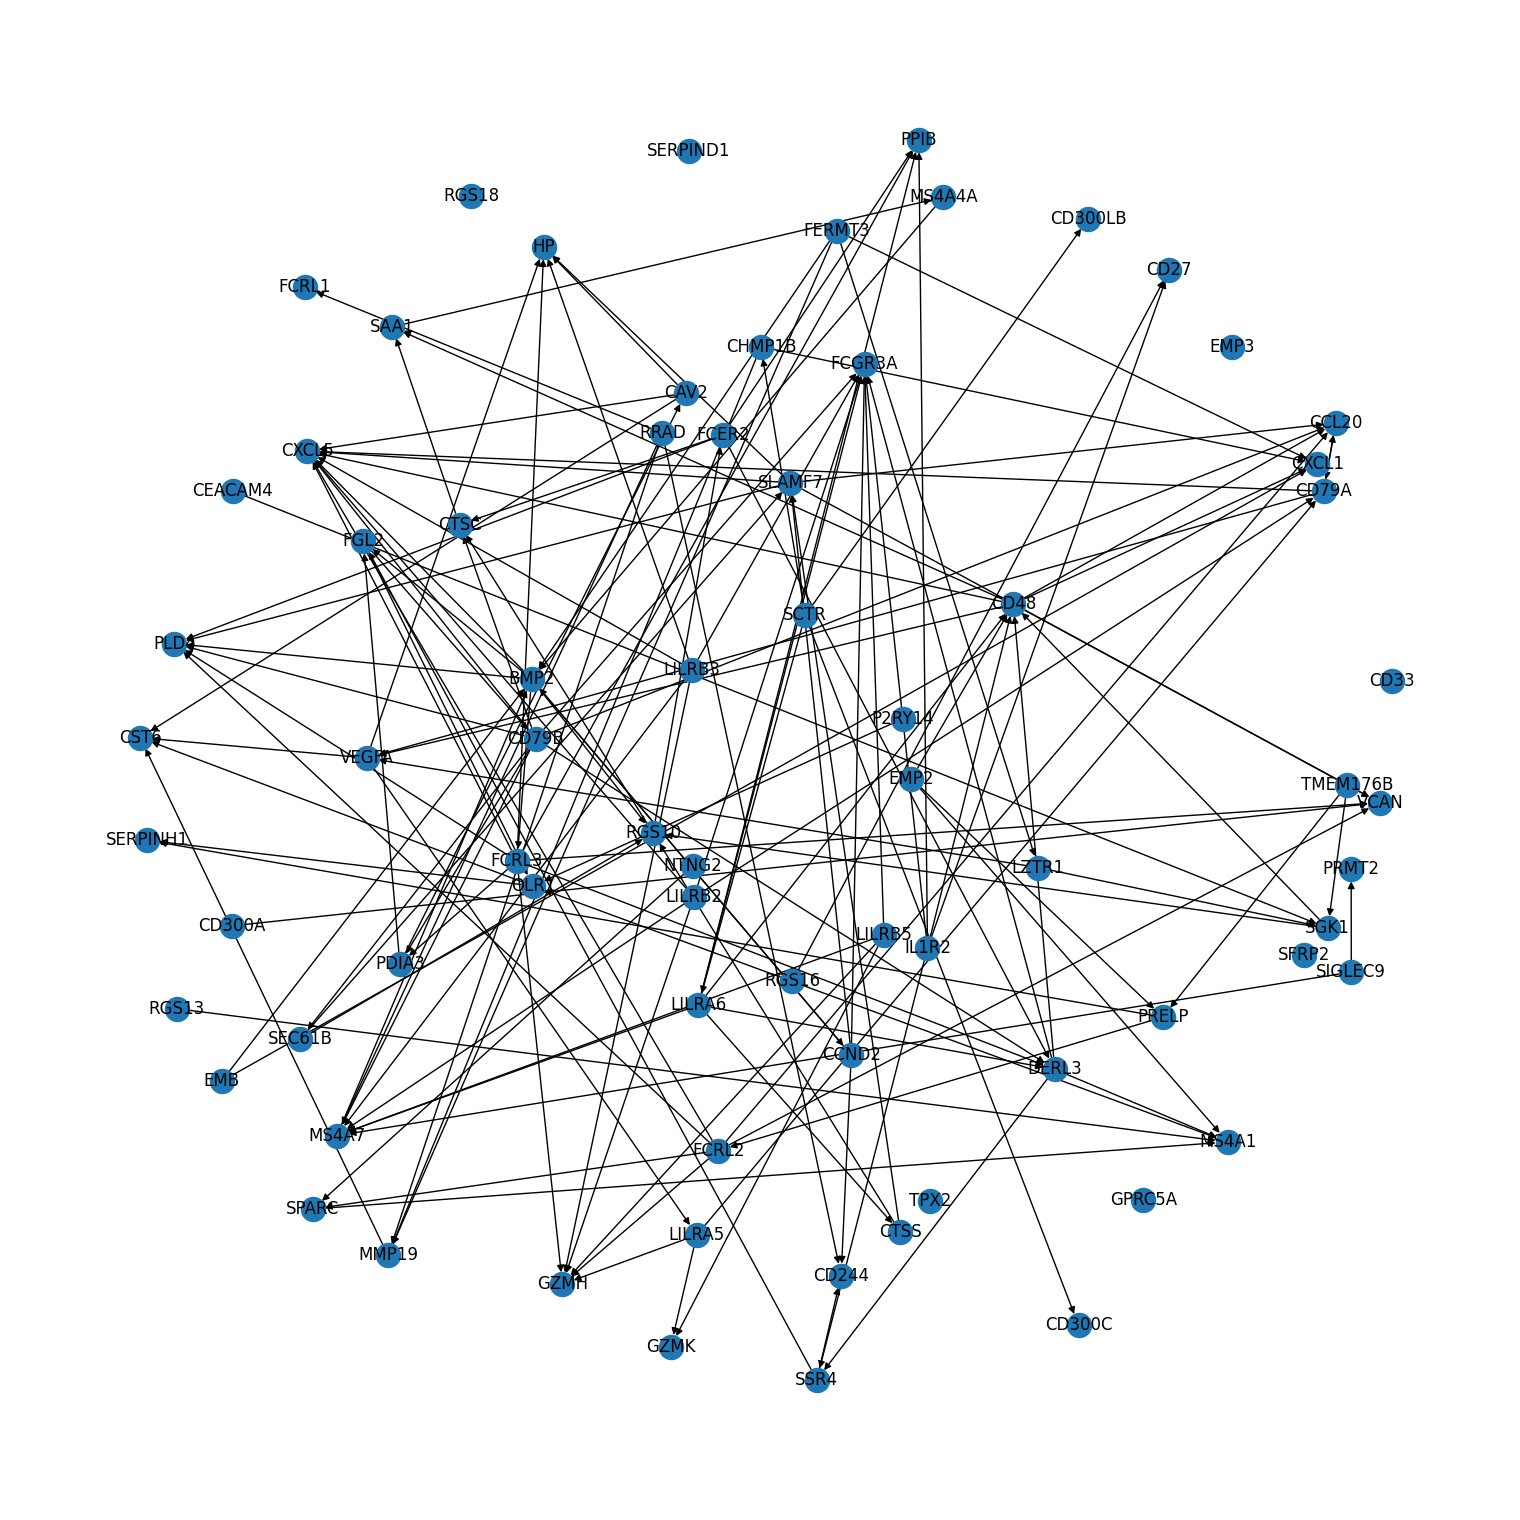

In [77]:
plot_subgraph_of(grn, 'IRF4', using="Targets", max_edges=100, plot_size=15)


In [121]:
def fileToList(filename, strconv=lambda x: x):
    """
    loads an input file with a\\n b\\n.. into a list [a,b,..]
    """
    with open(filename) as f:
        return [strconv(val[:-1]) for val in f.readlines()]

In [122]:
TF = fileToList("../../../GRnnData/grnndata/TF.txt")

In [133]:
from gseapy import Msigdb
msig = Msigdb()
msig.list_dbver()
gmt = msig.get_gmt(category='h.all')

/home/ml4ig1/miniconda3/envs/scprint/lib/python3.10/site-packages/gseapy/msigdb.py:20: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  d = pd.read_html(resp.text)[0]
/home/ml4ig1/miniconda3/envs/scprint/lib/python3.10/site-packages/gseapy/msigdb.py:72: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  d = pd.read_html(resp.text)[0]


,Name,Last modified
0,6.0,2018-12-17 16:29
1,6.1,2018-12-17 16:29
2,6.2,2018-12-17 16:29
3,7.0,2020-01-27 04:43
4,7.1,2020-03-30 16:55
5,7.2,2020-09-18 23:33
6,7.3,2021-03-22 15:09
7,7.4,2021-04-02 14:38
8,7.5.1,2023-03-09 19:38
9,7.5,2022-01-13 01:00


In [136]:
msig.list_category()

/home/ml4ig1/miniconda3/envs/scprint/lib/python3.10/site-packages/gseapy/msigdb.py:72: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  d = pd.read_html(resp.text)[0]


['c1.all',
 'c2.all',
 'c2.cgp',
 'c2.cp.biocarta',
 'c2.cp.kegg',
 'c2.cp.pid',
 'c2.cp.reactome',
 'c2.cp',
 'c2.cp.wikipathways',
 'c3.all',
 'c3.mir.mir_legacy',
 'c3.mir.mirdb',
 'c3.mir',
 'c3.tft.gtrd',
 'c3.tft.tft_legacy',
 'c3.tft',
 'c4.all',
 'c4.cgn',
 'c4.cm',
 'c5.all',
 'c5.go.bp',
 'c5.go.cc',
 'c5.go.mf',
 'c5.go',
 'c5.hpo',
 'c6.all',
 'c7.all',
 'c7.immunesigdb',
 'c7.vax',
 'c8.all',
 'h.all',
 'msigdb']

2024-03-10 14:07:57,050 [INFO] Input dict object named with gs_ind_1
2024-03-10 14:07:57,052 [INFO] Input dict object named with gs_ind_4
2024-03-10 14:07:57,054 [INFO] User defined gene sets is given: ../../../GRnnData/grnndata/celltype.gmt
2024-03-10 14:07:57,666 [WARNING] Input library not found: GTEx_Tissue_Sample_Gene_Expression_Profiles_up. Skip
2024-03-10 14:07:57,669 [INFO] Run: KEGG_2016 
2024-03-10 14:07:58,679 [INFO] Run: gs_ind_1 
2024-03-10 14:07:58,682 [INFO] No hits return, for gene set: Custom139733341604800
2024-03-10 14:07:58,684 [INFO] Run: ENCODE_TF_ChIP-seq_2014 
2024-03-10 14:07:59,895 [INFO] Run: GO_Molecular_Function_2015 
2024-03-10 14:08:00,907 [INFO] Run: gs_ind_4 
2024-03-10 14:08:00,912 [INFO] Run: celltype.gmt 
2024-03-10 14:08:00,933 [INFO] Run: OMIM_Disease 
2024-03-10 14:08:01,863 [INFO] Run: WikiPathways_2016 
2024-03-10 14:08:02,870 [INFO] Run: GO_Cellular_Component_2015 
2024-03-10 14:08:03,878 [INFO] Run: TargetScan_microRNA 
2024-03-10 14:08:04,881

,Gene_set,Term,P-value,Adjusted P-value,Old P-value,Old adjusted P-value,Odds Ratio,Combined Score,Genes,Overlap
0,KEGG_2016,Osteoclast differentiation Homo sapiens hsa04380,0.001127,0.099147,0.0,0.0,5.926290,40.230559,LILRA6;IFNGR1;LILRB1;LILRB2;LILRB3;LILRB5,NaN
542,GO_Molecular_Function_2015,MHC class I protein binding (GO:0042288),0.000791,0.159750,0.0,0.0,inf,inf,LILRB1;LILRB2,NaN
543,GO_Molecular_Function_2015,helicase activity (GO:0004386),0.001529,0.159750,0.0,0.0,6.964990,45.156359,IFIH1;ZRANB3;DDX54;DDX52;CHD1,NaN
544,GO_Molecular_Function_2015,MHC class I receptor activity (GO:0032393),0.002329,0.162250,0.0,0.0,70.370370,426.608970,LILRB1;LILRB2,NaN
545,GO_Molecular_Function_2015,MHC protein binding (GO:0042287),0.004572,0.191122,0.0,0.0,35.172840,189.502018,LILRB1;LILRB2,NaN
546,GO_Molecular_Function_2015,protein phosphatase 1 binding (GO:0008157),0.004572,0.191122,0.0,0.0,35.172840,189.502018,LILRB1;LILRB2,NaN
777,OMIM_Disease,epidermolysis bullosa,0.028289,0.165032,0.0,0.0,inf,inf,COL7A1,NaN
778,OMIM_Disease,spinocerebellar ataxia,0.082516,0.165032,0.0,0.0,17.371951,43.338913,TTBK2,NaN
779,OMIM_Disease,obesity,0.082516,0.165032,0.0,0.0,17.371951,43.338913,AGRP,NaN
780,OMIM_Disease,lymphoma,0.082516,0.165032,0.0,0.0,17.371951,43.338913,TCL1A,NaN


In [129]:
enr2.results[enr2.results['Term']=="MEF2C"]

,Gene_set,Term,P-value,Adjusted P-value,Old P-value,Old adjusted P-value,Odds Ratio,Combined Score,Genes,Overlap


In [57]:
benchmark = ben.BenGRN(grn)

In [66]:
gt = benchmark.gt.grn

In [82]:
gt.loc[:,'IRF4']!=0

SYTL4      False
OR52I2     False
SLC2A5     False
FAM3A      False
ADH4       False
           ...  
HSD17B7    False
GDF10      False
ADCY10     False
GABRA6     False
COMMD7     False
Name: IRF4, Length: 6979, dtype: bool

In [85]:
gt.loc[:,gt.loc[:,'IRF4']!=0].columns

Index(['FOXO1', 'NFKB1_RELB', 'BCOR', 'RELA', 'NFKB2_REL', 'NFKB1', 'MAF',
       'BATF', 'NFKB1_NFKB2', 'REL_RELA', 'SPI1', 'NFKB1_REL', 'REL',
       'NFKB2_RELB', 'STAT4', 'STAT6', 'NFATC1', 'NFKB2_RELA', 'IRF5',
       'REL_RELB', 'BCL6', 'NFKB1_RELA', 'CEBPB', 'MYC', 'RELA_RELB', 'NFKB2',
       'RELB', 'IRF4'],
      dtype='object')

In [80]:
gt[:,gt['IRF4']!=0].columns

InvalidIndexError: (slice(None, None, None), SYTL4      False
OR52I2     False
SLC2A5     False
FAM3A      False
ADH4       False
           ...  
HSD17B7    False
GDF10      False
ADCY10     False
GABRA6     False
COMMD7     False
Name: IRF4, Length: 6979, dtype: bool)

intersection of 1240 genes


/home/ml4ig1/miniconda3/envs/scprint/lib/python3.10/site-packages/numpy/core/fromnumeric.py:84: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)
/home/ml4ig1/miniconda3/envs/scprint/lib/python3.10/site-packages/scipy/stats/_stats_py.py:5445: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))


{'intersection': 0.4226312201772324,
 'precision': 0.0009070354401093701,
 'recall': 0.04288377874456184,
 'accuracy': 0.000889037777663248,
 'spearman_corr': SignificanceResult(statistic=nan, pvalue=nan),
 'auc': 0.0010875259749916777}

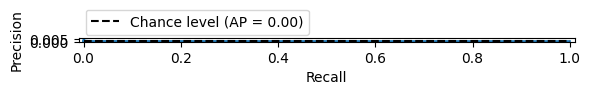

In [61]:
benchmark.do_tests()

In [ ]:
genie3_grn = ben.compute_genie3(grn.copy())
utils.metrics(genie3_grn)

In [ ]:
utils.plot_cluster(genie3_grn, stretch=5, min_dist=0.3, spread=1)